In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option("mode.chained_assignment", None)

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

## Idea for building the FIS model

 We collect the data for big-LITTLE core utilization and frequency, the memory at ondemand and the GPU util. I plan on setting all the values at 250 ms. So that it is in-tandem with what we decided. 

 Now the next steps are as follows :- 
 1. Sanity check -- check the correaltion of the utilization and the cost among all the three/four values
 2. Modeling -- build a conditional probability model for the likelihood of the others value; for eg in cluster 1 -- what is the likely value of say the CPU util when others are fuzzified
 3. The build a fuzzy arma model, using the weights and the linear regr value
 4. Then use predicition using that model --
 5. And finally predict the CPU usage say based on each cluster-- or sort of defuzzification
    

In [4]:
# Get the data --
utilData = pd.read_csv('UtilTRNS.csv')

In [5]:
utilData.head()

,Time,sCPU,cCost,sFreq,bCPU,bUtil,bFreq,Mem,mCost,mFreq,GPU,gCost,gFreq
0,1.700423e+09,sCPU,0,1400000,bCPU,0,2000000,Mem,0,825000000,GPU,0,600000000
1,1.700423e+09,sCPU,30,1400000,bCPU,0,2000000,Mem,1,825000000,GPU,0,600000000
2,1.700423e+09,sCPU,32,1400000,bCPU,0,2000000,Mem,0,825000000,GPU,0,600000000
3,1.700423e+09,sCPU,25,1400000,bCPU,0,2000000,Mem,1,825000000,GPU,0,600000000
4,1.700423e+09,sCPU,70,1400000,bCPU,0,2000000,Mem,3,825000000,GPU,0,600000000


## The code for creating a fuzzy values for the other aspects of the code --
1. Maybe use the history list to create a clustering of the values --
2. Add the two different values and then group them together.

<Axes: >

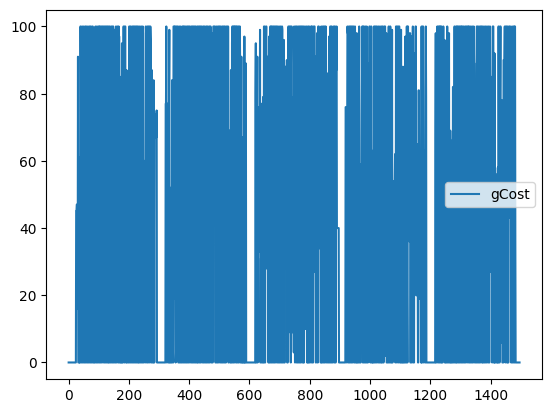

In [6]:
utilData[['gCost']].plot()

In [7]:
dCPU = utilData.cCost.to_numpy()
dMem = utilData.mCost.to_numpy()
dGPU = utilData.gCost.to_numpy()

In [8]:
fuzzyData = utilData[['mCost','gCost']].to_numpy()

In [9]:
fuzzyData_test = fuzzyData[:1000]

In [10]:
max(dCPU)

100

In [11]:
import skfuzzy as fuzz

In [12]:
n_cluster = 5

In [13]:
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(fuzzyData_test.T, n_cluster, 2, error=0.005, maxiter=1000, init=None)

In [14]:
p

25

In [15]:
fuzzyData.shape

(1497, 2)

In [16]:
u.shape

(5, 1000)

In [17]:
ut,u0t,dt,jmt,pt,fpct = fuzz.cluster.cmeans_predict(fuzzyData[1000:1001].T,cntr,2,error=0.005,maxiter=1000,init=None,seed=0)

In [18]:
ut

array([[0.17440173],
       [0.01991902],
       [0.05096335],
       [0.58034328],
       [0.17437263]])

In [19]:
import statsmodels.api as sm

In [20]:
X_train = sm.add_constant(fuzzyData_test)
X_train.shape

(1000, 3)

In [21]:
model0 = sm.WLS(dCPU[1:1001],X_train,weights=u[0])
model1 = sm.WLS(dCPU[1:1001],X_train,weights=u[1])
model2 = sm.WLS(dCPU[1:1001],X_train,weights=u[2])
model3 = sm.WLS(dCPU[1:1001],X_train,weights=u[3])
model4 = sm.WLS(dCPU[1:1001],X_train,weights=u[4])

In [22]:
result0 = model0.fit()
result1 = model1.fit()
result2 = model2.fit()
result3 = model3.fit()
result4 = model4.fit()

In [23]:
dCPU[1001]

36

In [24]:
fuzzyData[1000]

array([ 9, 25])

In [25]:
val = [0,0,0,0,0]

In [26]:
val[0]=result0.get_prediction([1,9,25]).predicted_mean

In [27]:
val[1] = result1.get_prediction([1,9,25]).predicted_mean

In [28]:
val[2] = result2.get_prediction([1,9,25]).predicted_mean

In [29]:
val[3] = result3.get_prediction([1,9,25]).predicted_mean

In [30]:
val[4]= result4.get_prediction([1,9,25]).predicted_mean

In [31]:
Out = [val[i]*ut[i] for i in range(5)]

In [32]:
sum(Out)

array([45.28547581])

## Get started with the coding part of fuzzy logic

In [33]:
# Get the training of the clusters and the model values
import skfuzzy as fuzz
import statsmodels.api as sm
import numpy as np
import pandas as pd
#------ Cluster related code -------

def train_Cluster(data, n_cluster = 5):
    print("The stats of the training data: features {} and size {}".format(len(data[0]), len(data)))
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, n_cluster, 2, error=0.005, maxiter=1000, init=None, seed = 0)
    print("The centroid values are \n {}".format(cntr))
    return cntr,u

def getCluster(data, cntr):
    print("The stats of the training data: shape".format(data.shape))
    ut,u0t,dt,jmt,pt,fpct = fuzz.cluster.cmeans_predict(data.T,cntr,2,error=0.005,maxiter=1000,init=None,seed=0)
    return ut

#------- Estimation related code ---------------
def get_shiftedData(data,shiftP=1):
    if shiftP < 1:
        print('Error!! The shift should be atleast one')
        return None
    df_temp = pd.DataFrame()
    df_temp['endog'] = data
    
    for i in range(1,shiftP+1):
        df_temp['endog_%d'% i] = df_temp['endog'].shift(i)

    df_out = df_temp.dropna()
    shiftedData = df_out.iloc[:,1:shiftP+1].values.reshape(-1,shiftP)
    return shiftedData
    
    
def train_AR(yData, xData, shiftP=3, weight=None):
    if len(yData) < 2*shiftP :
        print("Cannot train on small corupus")
        return None
    elif len(yData) != len(xData):
        print("Incorrect format of x and y values")
        return None
    #Now we train
    yShift = get_shiftedData(yData,shiftP)
    xShift = np.array(xData[shiftP-1:-1]) # We need to ensure that we are using the historical value while predicting the yVal
    newX = np.hstack((yShift,xShift))
    if weight is None:
        weight = np.ones(len(yData))
    weightShift = weight[shiftP:]
    #----- curate the data -----
    new_x = sm.add_constant(newX)
    ytrain = yData[shiftP:]
    model = sm.WLS(ytrain,new_x,weights=weightShift)
    result = model.fit()
    return result




def test_AR(model, yData, xData):
    xRun  = sm.add_constant(xData) # Adding the constant
    y_pred = model.get_prediction(xRun).predicted_mean
    y_act =  yData
    df_plot = pd.DataFrame()
    df_plot['Actual'] = yData
    df_plot['Predicted'] = y_pred
    df_plot[['Actual','Predicted']].plot()
    return

    

# Running the code using data modifications --not functional 

In [34]:
# Get the training of the clusters and the model values
import skfuzzy as fuzz
import statsmodels.api as sm
import numpy as np
import pandas as pd
import math
#------ Cluster related code -------

def train_Cluster(data, n_cluster = 5):
    # print("The stats of the training data: features {} and size {}".format(len(data[0]), len(data)))
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, n_cluster, 2, error=0.005, maxiter=1000, init=None, seed = 0)
    # print("The centroid values are \n {}".format(cntr))
    return cntr,u

def getCluster(data, cntr):
    # print("The stats of the training data: shape".format(data.shape))
    ut,u0t,dt,jmt,pt,fpct = fuzz.cluster.cmeans_predict(data.T,cntr,2,error=0.005,maxiter=1000,init=None,seed=0)
    return ut


def simple_train(yData, xData, weight=None):
    if weight is None:
        weight = np.ones(len(yData))

    new_x = sm.add_constant(xData)
    model = sm.WLS(yData,new_x,weights=weight)
    result = model.fit()
    return result

def simple_test(model , xData, yActual):
    newX = sm.add_constant(xData)
    y_pred = model.get_prediction(newX).predicted_mean
    # df_plot = pd.DataFrame()
    # df_plot['Actual'] = yActual
    # df_plot['Predicted'] = y_pred
    # df_plot[['Actual','Predicted']].plot()
    return y_pred


from sklearn.metrics import mean_squared_error

# rms = mean_squared_error(y_actual, y_predicted, squared=False)
def rmse(predictions, targets):
    return mean_squared_error(targets, predictions, squared=False)

def highlight(indices,ax):
    i=0
    while i<len(indices):
        ax.axvspan(indices[i]-0.5, indices[i]+0.5, facecolor='red', edgecolor='none', alpha=.2)
        i+=1
    ax.legend(bbox_to_anchor=(1.0, 1.0))

In [43]:
## Some global variable setting
shiftAR = 8
shiftARX = 3
trainIDX = 150
testIDX = 150
N_CLUST = 5
cFreq = 'sFreq'
mFreq = 'mFreq'
gFreq = 'gFreq'

endog = 'gCost'
exog = 'cCost'
exog1 = 'mCost'
rFreq = gFreq

### Test values IDX
TestIDX = 70 # How many steps to run
## Is there any other things.... to do
freq_dict = {}
freq_dict['gFreq'] = [177000000,266000000,350000000,420000000,480000000,600000000]
freq_dict['mFreq'] = [165000000,206000000,275000000,413000000,543000000,633000000,728000000,825000000]#,933000000]
freq_dict['sFreq'] = [200000,300000,400000,500000,600000,700000,800000,900000,1000000,1100000,1200000,1300000,1400000]


In [44]:
## Getting the data ready for test train split and bucnch of experiments
# complete_data = pd.read_csv('UtilTRNS.csv')
complete_data = pd.read_csv('UtilCopy.csv')
# complete_data = pd.read_csv('./UtilTestFinal')
print(complete_data.shape)
complete_data.head()


(331, 13)


,Time,sCPU,cCost,sFreq,bCPU,bUtil,bFreq,Mem,mCost,mFreq,GPU,gCost,gFreq
0,1.700326e+09,sCPU,14,1400000,bCPU,0,2000000,Mem,15,825000000,GPU,0,600000000
1,1.700326e+09,sCPU,5,1400000,bCPU,0,2000000,Mem,15,825000000,GPU,0,600000000
2,1.700326e+09,sCPU,15,1400000,bCPU,0,2000000,Mem,16,825000000,GPU,0,600000000
3,1.700326e+09,sCPU,3,1400000,bCPU,0,2000000,Mem,15,825000000,GPU,0,600000000
4,1.700326e+09,sCPU,9,1400000,bCPU,0,2000000,Mem,16,825000000,GPU,0,600000000


In [45]:
# # For utilTestFinal
# complete_data['cCost'] =  complete_data['bUtil']*complete_data['bFreq']/1400000
# complete_data['mCost'] = complete_data['mUtil']*complete_data['mFreq']/825000000
# # print(max(complete_data['mCost']))
# complete_data['gCost'] = 0
# complete_data['gFreq'] = 600000000

Testing the cost of:  gCost -- RMSE 4.375288808066095


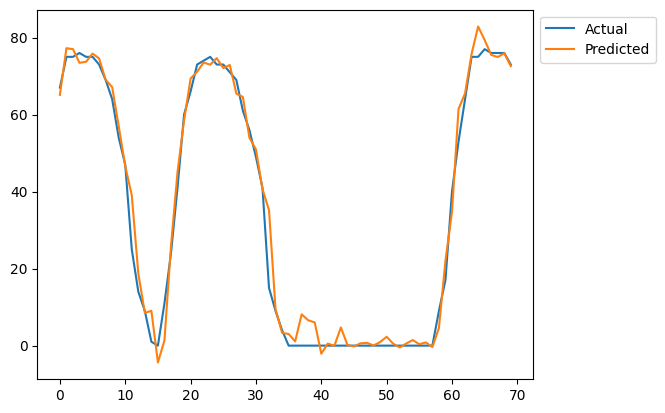

In [46]:
## Getting only the relevant columns
data_df = pd.DataFrame()
data_df = complete_data[[endog,exog,exog1]]
freq_df = pd.DataFrame()
freq_df = complete_data[[endog,exog,exog1,cFreq,mFreq,gFreq]]

# data_df.head()
# Creating Data for AR
for i in range(1,shiftAR+1):
    data_df['%s_%d'%(endog,i)] = data_df[endog].shift(i)
    freq_df['%s_%d'%(endog,i)] = freq_df[endog].shift(i)
data_df[exog] = data_df[exog].shift(1)
freq_df[exog] = freq_df[exog].shift(1)
for i in range(1,shiftARX+1):
    data_df['%s_%d'%(exog,i)] = data_df[exog].shift(i+1)   
    freq_df['%s_%d'%(exog,i)] = freq_df[exog].shift(i+1)   
data_df[exog1] = data_df[exog1].shift(1)
freq_df[exog1] = freq_df[exog1].shift(1)
for i in range(1,shiftARX+1):
    data_df['%s_%d'%(exog1,i)] = data_df[exog1].shift(i+1) 
    freq_df['%s_%d'%(exog1,i)] = freq_df[exog1].shift(i+1) 
data_df = data_df.dropna() # Dropping NA
freq_df = freq_df.dropna() # Getting the Freq values without the NA
# Train Test Divide
train_df = data_df.iloc[:trainIDX,:]
test_df = data_df.iloc[testIDX:,:]

test_freq_df = freq_df.iloc[testIDX:,:]

y_train = train_df.iloc[:,0].to_numpy()
x_train = train_df.iloc[:,1:].to_numpy()
y_test = test_df.iloc[:,0].to_numpy()
x_test = test_df.iloc[:,1:].to_numpy()
####### Trainign the data
cluster_center,prob = train_Cluster(x_train[:,:],n_cluster = N_CLUST)  #Cluster Indices

## Train the model
model = []
for i in range(N_CLUST):
    out_model = simple_train(y_train,x_train,weight = prob[i,:])
    model.append(out_model)

######## Testing the results

yPred = [ 0 for i in range(N_CLUST)]
probPred = getCluster(x_test[:TestIDX], cluster_center)

## Test the values
for i in range(N_CLUST):
    y_t = simple_test(model[i],x_test[:TestIDX], y_test[:TestIDX])
    yPred[i] = np.array(probPred[i,:])*np.array(y_t)

y_target = sum(yPred)
y_out = y_test[:TestIDX]
print("Testing the cost of: ", endog, "-- RMSE", rmse(y_out,y_target))
# Plot the results
df_plot = pd.DataFrame()
df_plot['Actual'] = y_out
df_plot['Predicted'] = y_target
ax = df_plot[['Actual','Predicted']].plot()
ax.legend(bbox_to_anchor=(1.0, 1.0))
#### Done

In [47]:
test_freq_df[[cFreq,mFreq,gFreq]] # This is how you get the frequency of the expected value of the test data

,sFreq,mFreq,gFreq
158,1400000,825000000,600000000
159,1400000,825000000,600000000
160,1400000,825000000,600000000
161,1400000,825000000,600000000
162,1400000,825000000,600000000
...,...,...,...
326,1400000,825000000,600000000
327,1400000,825000000,600000000
328,1400000,825000000,600000000
329,1400000,825000000,600000000


In [48]:
Y_pred = y_target
Y_act = y_out
FreqOut = test_freq_df[rFreq].iloc[:TestIDX].to_numpy()


## Get the appropriate frequency of the resources -- and fractional energy savings.

In [49]:

pred_freq = []
act_freq = []
effective_y = []
for idx in range(len(Y_pred)):
    act_freq.append(FreqOut[idx])
    for v in freq_dict[rFreq]:
        val = Y_pred[idx]*max(freq_dict[rFreq])/v
        if val <= 100 or v == max(freq_dict[rFreq]):
            if val > 100 and v == max(freq_dict[rFreq]):
                pred_freq.append(min(v*val/100,v))
                effective_y.append(Y_act[idx]*max(freq_dict[rFreq])/v)
            else:
                pred_freq.append(v)
                effective_y.append(Y_act[idx]*max(freq_dict[rFreq])/v)

            break

error_pred = sum( i > 100 for i in effective_y )      
print("Number of prediction that will cause stalling in performance of ",endog," due to > 100 Util demand: ",error_pred)
print("Percentage error causing stall", error_pred * 100.0/ len(effective_y),"%")

#### Get the energy saving fraction
energy_ratio = 0
for idx in range(len(pred_freq)):
    energy_ratio += math.ceil(effective_y[idx]/100.)*(pred_freq[idx]/act_freq[idx])**2

energy_save =  1.0 - (energy_ratio / len(pred_freq))

print("Fractional energy saved by our approach : ", energy_save)
    
    

Number of prediction that will cause stalling in performance of  gCost  due to > 100 Util demand:  0
Percentage error causing stall 0.0 %
Fractional energy saved by our approach :  0.7114172619047617


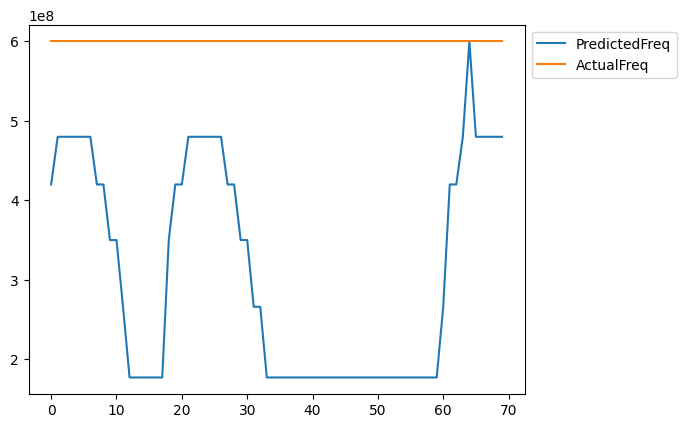

In [50]:
df_freq = pd.DataFrame()

df_freq['PredictedFreq'] = pred_freq
df_freq['ActualFreq'] = act_freq
# df_freq['MaxFreq'] = max(freq_dict[rFreq])
df_freq['EffUtil'] = effective_y
df_freq['ActUtil'] = Y_act
# df_freq['MaxPoss'] = 100
ax = df_freq[['PredictedFreq','ActualFreq']].plot()
highlight(df_freq[df_freq['EffUtil'] > 100].index, ax)

## Control Theory Implementation

In [42]:
# In the following section, we will use the LQR or MPC to control the frequency of the system. 
# The plan involves utilizing the utilization history, and maybe..actual frequency to adjust the predicted value.
# Note: We can include the other frequency values, such as the Mem and GPU to predict the frequency.. utilizing CRAVE work

In [51]:
def dlqr_calculate(A, B, Q, R):
    from scipy.linalg import solve_discrete_are, inv
    P = solve_discrete_are(A, B, Q, R)  #Riccati Solution 
    K = inv(B.T@P@B + R)@B.T@P@A    #K = (B^T P B + R)^-1 B^T P A 
    return K


In [54]:
# We can add it to ARMA model, and wonder is it same as that??